In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(5.5, 5)):
    if kind == 'Completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        labels = ['Normal', 'Anomaly'] # recast ['Normal', 'Other']
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'Purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        labels = ['Normal', 'Anomaly'] # recast ['Normal', 'Other']
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":20}, cbar=False)
    plt.title(title, fontsize=20, pad=10)
    plt.ylabel('True class', fontsize=22)
    plt.xlabel('Predicted class', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.show()

In [4]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

#num=3039 #5000
#n_classes=11 #12
#n_epochs=4000 #500
#fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

df_folder_path = f"../figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes/"
# Files used for actual model gen    
#x_train_all_latent_df = pd.read_csv(f'{df_folder_path}/x_train_all_3sdims_df.csv.gz', compression='gzip', index_col=0)
#x_test_all_latent_df = pd.read_csv(f'{df_folder_path}/x_test_all_3sdims_df.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_train = x_train_all_latent_df
#dataset_bank_tns_df_resampled_test = x_test_all_latent_df


# test here isn't split into test+val set (val set used for VAE)
dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc91973,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535,Fake,TDE,-99.00000,None
ZTFabc46594,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221,Fake,TDE,-99.00000,None
ZTFabc20988,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310,Fake,TDE,-99.00000,None


In [5]:
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20aaybwth,0.384511,0.549172,0.250000,0.125000,0.324167,0.769022,0.619796,0.227901,3.039816,-0.000004,...,0.065300,0.089100,0.114300,0.066299,18.578022,0.023904,Yes_TNS,None,-99.00000,ZTF
ZTF21abhvfrj,0.477448,1.131876,0.090909,0.090909,0.329433,0.954895,0.633796,0.214027,5.379689,-0.001774,...,0.904800,1.048300,0.646000,-3.536699,11.699969,0.344573,Yes_TNS,None,-99.00000,ALeRCE
ZTF20acngnvf,0.221461,0.330890,0.235294,0.058824,0.311743,0.442923,0.306310,0.137998,0.532772,0.001336,...,-0.086601,-0.048399,-0.113600,-0.270000,38.753182,2.917582,No_TNS,None,-99.00000,None
ZTF20aciucub,0.223271,0.301653,0.285714,0.000000,0.343634,0.446543,0.400569,0.169672,1.121545,0.007691,...,0.836599,0.839901,0.759600,0.988201,57.223518,0.566740,Yes_TNS,None,-99.00000,ALeRCE
ZTF21abcfnuk,0.240122,0.239833,0.285714,0.000000,0.402769,0.480244,0.435988,0.232947,-0.639529,0.017278,...,0.705400,0.707901,0.560101,0.530401,15.985091,0.185905,Yes_TNS,None,-99.00000,SGLF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [6]:
Counter(dataset_bank_tns_df_resampled_train.tns_cls)

Counter({'None': 2656,
         'SN Ia': 2656,
         'SN II': 2656,
         'SN Ib': 2656,
         'SN IIP': 2656,
         'TDE': 2656,
         'SN IIn': 2656,
         'SLSN-II': 2656,
         'SN IIb': 2656,
         'SN Ic': 2656,
         'SN Ic-BL': 2656,
         'SN Ia-91T-like': 2656})

In [7]:
Counter(dataset_bank_tns_df_resampled_test.tns_cls)

Counter({'None': 1160,
         'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

In [8]:
# Try without None
dataset_bank_tns_df_resampled_train = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']

x_train = pd.concat([dataset_bank_tns_df_resampled_train.iloc[:, 0:120], 
                     dataset_bank_tns_df_resampled_train.iloc[:, 124:]], axis=1)
x_test = pd.concat([dataset_bank_tns_df_resampled_test.iloc[:, 0:120], 
                     dataset_bank_tns_df_resampled_test.iloc[:, 124:]], axis=1)

x_train_all = dataset_bank_tns_df_resampled_train 
x_test_all = dataset_bank_tns_df_resampled_test

# Normalize the input data & validation data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

x_test_mean = np.mean(x_test, axis=0)
x_test_std = np.std(x_test, axis=0)
x_test_normalized = (x_test - x_train_mean) / x_train_std # scale test by train

In [9]:
di  = {'CV': 'OOS', 
      'SLSN-I': 'OOS', 
      'SLSN-II': 'Other', 
      'SN II': 'Normal', 
      'SN IIP': 'Normal', 
      'SN IIb': 'Other', 
      'SN IIn': 'Other',
      'SN Ia': 'Normal', 
      'SN Ia-91T-like': 'Normal', 
      'SN Ia-CSM': 'Other',
      'SN Ia-91bg-like': 'Other',
      'SN Ia-pec': 'Other', 
      'SN Ib': 'Other', 
      'SN Ib/c': 'OOS',
      'SN Ibn': 'OOS',
      'SN Ic': 'Other',
      'SN Ic-BL': 'Other', 
      'TDE': 'Other',
      'None': 'OOS',
      'SN': 'OOS',
      'SN I': 'OOS',
      'AGN': 'OOS'}

x_train_all = x_train_all.replace({"tns_cls": di})
x_test_all = x_test_all.replace({"tns_cls": di})
x_train_all

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,Normal,0.06975,ALeRCE
ZTF21aatvcdl,1.001925,0.535585,0.384615,0.076923,0.355134,2.003849,1.392731,0.589785,1.890188,0.011990,...,0.310101,0.245600,0.215601,0.188101,1.118396,0.810604,Yes_TNS,Normal,0.05000,ALeRCE
ZTF20ackzfvn,0.842765,0.292838,0.285714,0.000000,0.347289,1.685530,1.470047,0.522483,1.647548,-0.057671,...,0.381500,0.568100,0.528400,0.385101,172.179993,0.152137,Yes_TNS,Normal,0.01700,AMPEL
ZTF21abngbrl,0.734040,0.614425,0.125000,0.000000,0.424395,1.468081,1.324121,0.883477,-0.647679,0.022412,...,2.400501,2.056900,2.181299,1.926700,136.301710,3.633416,Yes_TNS,Other,0.03000,ALeRCE
ZTF21aaaroyw,0.411922,0.292416,0.222222,0.000000,0.347490,0.823845,0.629479,0.208841,1.513798,-0.006436,...,1.400800,1.457999,1.562500,1.456800,65.883768,0.599778,Yes_TNS,Other,0.04360,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc91973,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535,Fake,Other,-99.00000,None
ZTFabc46594,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221,Fake,Other,-99.00000,None
ZTFabc20988,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310,Fake,Other,-99.00000,None


In [10]:
x_train = x_train.iloc[:, 0:120] 
x_test = x_test.iloc[:, 0:120] 

x_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,6.417160,28.099199,0.218201,0.604300,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821
ZTF21aatvcdl,1.001925,0.535585,0.384615,0.076923,0.355134,2.003849,1.392731,0.589785,1.890188,0.011990,...,3.865140,13.535500,0.170500,0.299500,0.310101,0.245600,0.215601,0.188101,1.118396,0.810604
ZTF20ackzfvn,0.842765,0.292838,0.285714,0.000000,0.347289,1.685530,1.470047,0.522483,1.647548,-0.057671,...,5.579200,19.530100,0.114399,0.244598,0.381500,0.568100,0.528400,0.385101,172.179993,0.152137
ZTF21abngbrl,0.734040,0.614425,0.125000,0.000000,0.424395,1.468081,1.324121,0.883477,-0.647679,0.022412,...,12.039500,27.575800,-0.179399,0.717699,2.400501,2.056900,2.181299,1.926700,136.301710,3.633416
ZTF21aaaroyw,0.411922,0.292416,0.222222,0.000000,0.347490,0.823845,0.629479,0.208841,1.513798,-0.006436,...,15.069100,21.057301,0.118999,1.267200,1.400800,1.457999,1.562500,1.456800,65.883768,0.599778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc91973,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,5.658320,23.231739,0.049878,0.413701,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535
ZTFabc46594,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,2.332852,3.105119,0.225153,-0.055093,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221
ZTFabc20988,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,3.818522,13.005092,0.128931,0.066699,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310


In [11]:

n_estimators=100 #3500
max_depth=35 #35
random_state=11
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
#class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
#       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"
class_weight={"Normal": 1, "Other": 1} #"balanced"

figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/comparing_algs/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/comparing_algs/model"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

cm_path = f"{figure_path}/confusion_matrix/"
if not os.path.exists(cm_path):
    os.makedirs(cm_path)

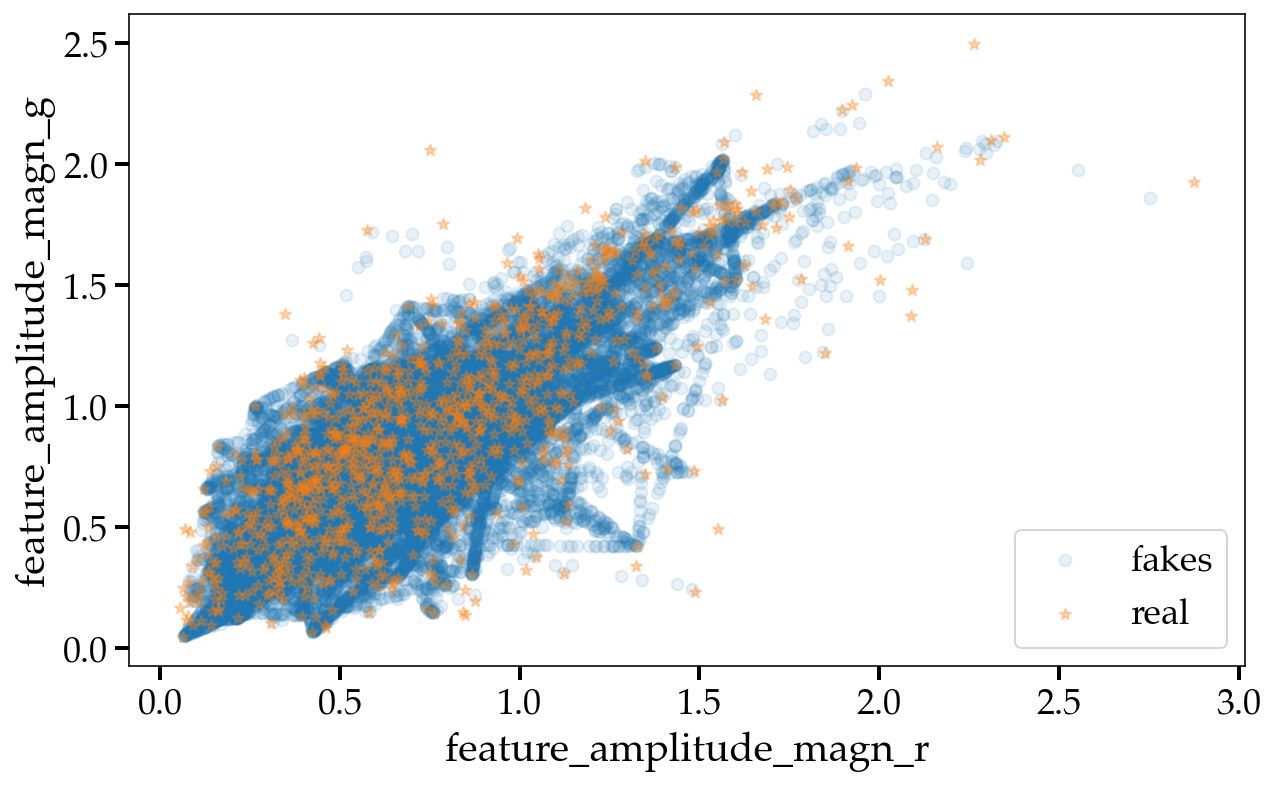

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_tns_df_resampled_train[~dataset_bank_tns_df_resampled_train.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['feature_amplitude_magn_r'], fakes_df['feature_amplitude_magn_g'], alpha=0.1, marker='o', label='fakes')
ax.scatter(real_df['feature_amplitude_magn_r'], real_df['feature_amplitude_magn_g'], alpha=0.3, marker='*',label='real')

plt.xlabel('feature_amplitude_magn_r')
plt.ylabel('feature_amplitude_magn_g')

#plt.xlim(-15, 20)
#plt.ylim(-15, 25)

plt.legend(loc='lower right')
plt.savefig(f'{figure_path}/fakes_vs_real_SMOTE.jpg', dpi=300, bbox_inches='tight')

plt.show()

In [62]:
import itertools
marker = itertools.cycle(('.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd')) 

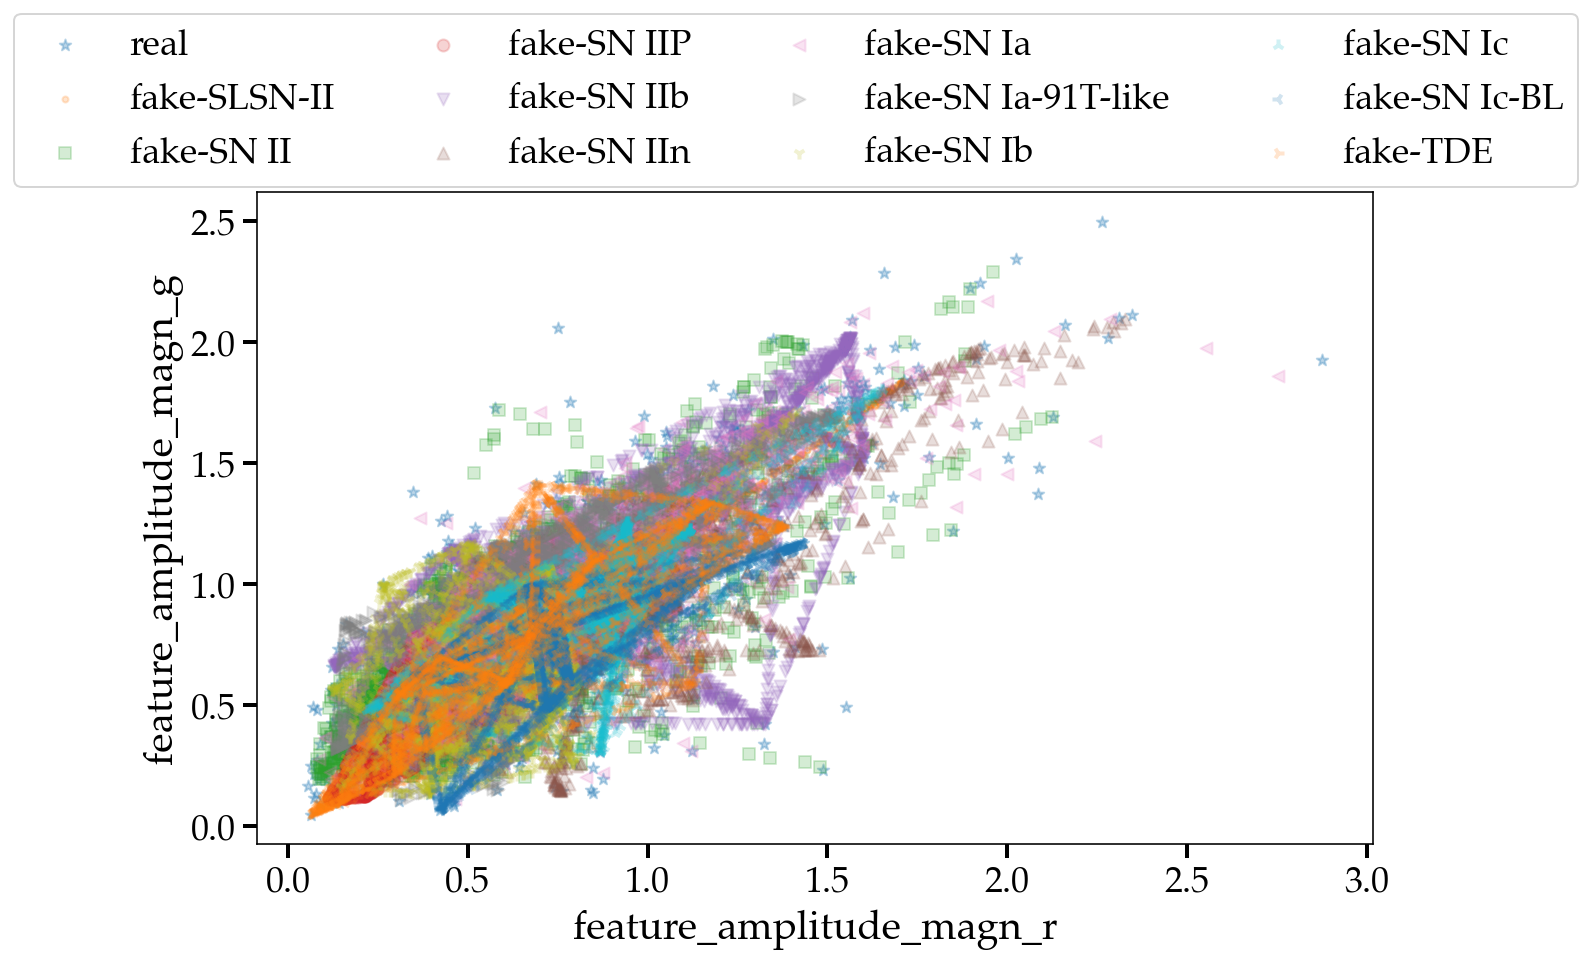

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_tns_df_resampled_train[~dataset_bank_tns_df_resampled_train.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.index.str.startswith('ZTFabc')]

ax.scatter(real_df['feature_amplitude_magn_r'], real_df['feature_amplitude_magn_g'], alpha=0.3, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(real_df.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['feature_amplitude_magn_r'], fakes_cls_df['feature_amplitude_magn_g'], alpha=0.2, marker=marker, label=f'fake-{cls}')

plt.xlabel('feature_amplitude_magn_r')
plt.ylabel('feature_amplitude_magn_g')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.3))

plt.savefig(f'{figure_path}/fakes_vs_real_SMOTE_cls.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Train Random Forest Classifer

In [12]:
%%time

# best hyperparams for tree based algs

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             random_state=random_state, 
                             max_features=max_features,
                             class_weight=class_weight,
                             verbose=1, 
                             n_jobs=-1)

clf.fit(x_train, np.array(x_train_all['tns_cls']))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s


CPU times: user 2min 33s, sys: 385 ms, total: 2min 34s
Wall time: 20.6 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.5s finished


RandomForestClassifier(class_weight={'Normal': 1, 'Other': 1}, max_depth=35,
                       max_features=35, n_jobs=-1, random_state=11, verbose=1)

In [13]:
pickle.dump(clf, open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'wb'))


In [14]:
# Load pickle

with open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
    clf = pickle.load(f)

In [15]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(x_test)

# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(x_test_all.index)

# USE clf.classes_ and row.values if you don't train on the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[np.argmax(row.values)], axis=1)

df2 = pd.concat([x_test_all, df], axis=1)
df2 = df2.replace({"tns_cls": di})
df2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group,Normal,Other,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.479000,17.508340,0.363381,Yes_TNS,Normal,0.076000,ALeRCE,80.436006,19.563994,Normal
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,1.677900,127.987642,1.280643,Yes_TNS,Other,0.023563,ZTF,32.037458,67.962542,Other
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.308001,73.202796,0.245163,Yes_TNS,Normal,0.048167,ZTF,70.000000,30.000000,Normal
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,1.170200,29.489402,0.282454,Yes_TNS,Normal,0.041000,ALeRCE,94.000000,6.000000,Normal
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,-0.067900,37.216605,4.749794,Yes_TNS,Normal,0.070000,ALeRCE,79.000000,21.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,1.092001,48.668157,0.124452,Yes_TNS,Normal,0.037437,ALeRCE,92.000000,8.000000,Normal
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.422300,58.550706,0.012833,Yes_TNS,Normal,0.097780,AMPEL,86.000000,14.000000,Normal
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,1.225500,124.418488,0.916609,Yes_TNS,Normal,0.040000,ALeRCE,87.000000,13.000000,Normal


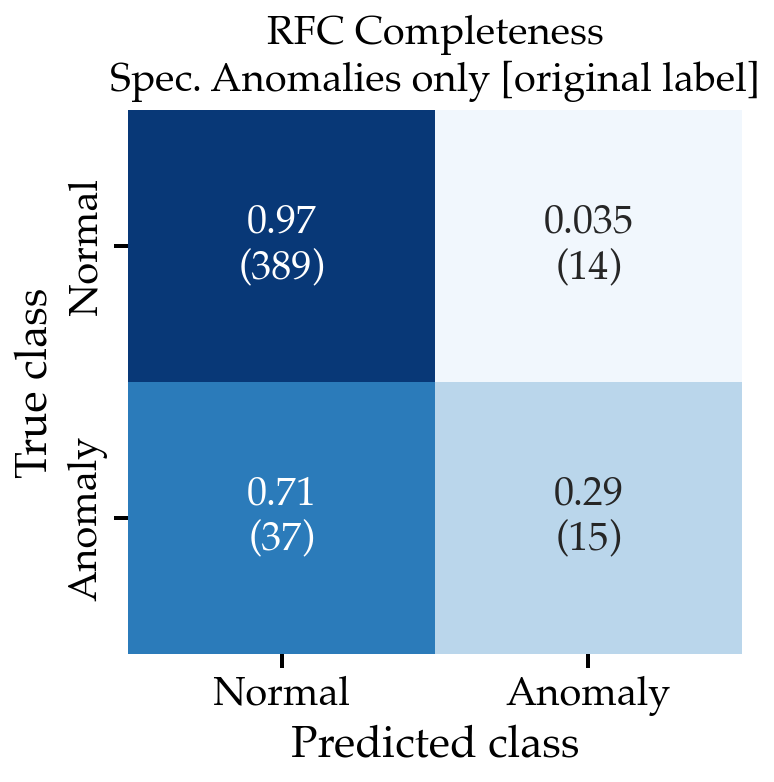

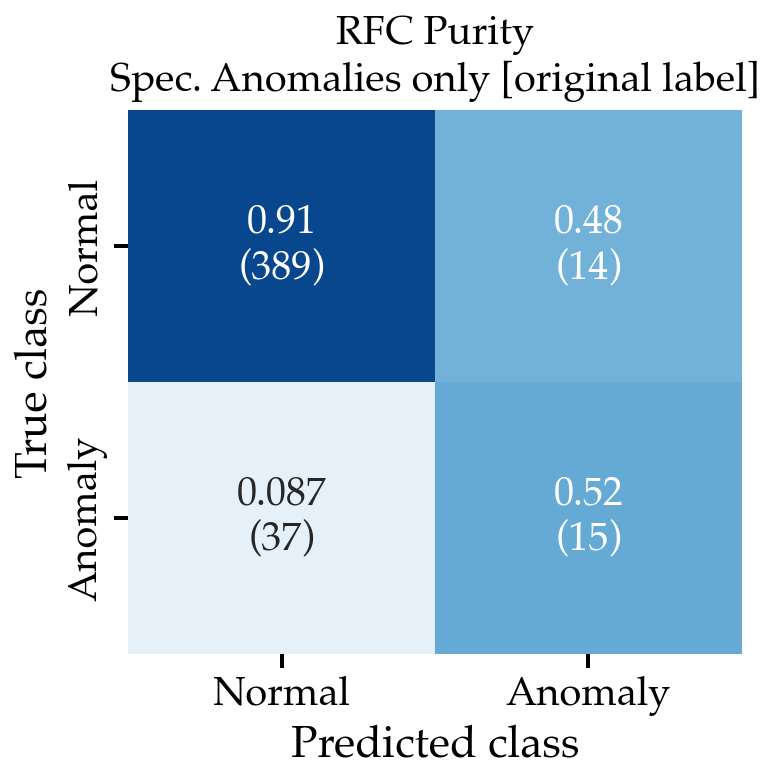

In [16]:
# Confusion matrices
title='spec_label_only'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['Completeness', 'Purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, #labels=class_names
             title=f'RFC {KIND}\nSpec. Anomalies only [original label]', kind=KIND)
    plt.savefig(f'{cm_path}/RFC_confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [17]:
from sklearn.metrics import classification_report
y_true = true_labels
y_pred = predicted_labels
target_names = class_names
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.52      0.29      0.37        52

    accuracy                           0.89       455
   macro avg       0.72      0.63      0.65       455
weighted avg       0.87      0.89      0.87       455



# Isolation Forest

In [18]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=n_estimators, 
                                random_state=random_state, 
                                contamination=0.13, #change
                                max_features=max_features, # 12 for with None cls
                                n_jobs=-1).fit(x_test).decision_function(x_test)

CPU times: user 268 ms, sys: 114 ms, total: 382 ms
Wall time: 286 ms


/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [19]:

# most anomalous samples (size of RFC predicted anomalous) before vetting
len_anom = len(anomaly_scores[(anomaly_scores) < 0])

most_anomalous_indices = np.argsort(anomaly_scores)[:len_anom] # 29 to match RFC
least_anomalous_indices = np.argsort(anomaly_scores)[len_anom:]# 29 to match RFC

most_anomalous_samples = df2.iloc[most_anomalous_indices] 
least_anomalous_samples = df2.iloc[least_anomalous_indices] 

most_anomalous_samples['IF_best_cls'] = "Other"
least_anomalous_samples['IF_best_cls'] = "Normal"

for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF20adadrhw Other Normal
https://alerce.online/object/ZTF21aavqphe Normal Normal
https://alerce.online/object/ZTF21aagojfe Normal Normal
https://alerce.online/object/ZTF20abptxls Normal Normal
https://alerce.online/object/ZTF20adagenq Normal Normal
https://alerce.online/object/ZTF21aagsypp Normal Normal
https://alerce.online/object/ZTF20acwfftd Normal Normal
https://alerce.online/object/ZTF20acounxo Other Normal
https://alerce.online/object/ZTF21abbwbja Normal Normal
https://alerce.online/object/ZTF18aawfofp Normal Normal
https://alerce.online/object/ZTF18acbvgtu Normal Normal
https://alerce.online/object/ZTF22aaayewi Normal Normal
https://alerce.online/object/ZTF20adadshh Normal Normal
https://alerce.online/object/ZTF20abrjmgi Normal Normal
https://alerce.online/object/ZTF20aatxryt Normal Normal
https://alerce.online/object/ZTF21aciqcge Normal Normal
https://alerce.online/object/ZTF21aanzcuj Normal Normal
https://alerce.online/object/ZTF21acptqqo Normal N

<ipython-input-19-b2be19f26651>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_anomalous_samples['IF_best_cls'] = "Other"
<ipython-input-19-b2be19f26651>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  least_anomalous_samples['IF_best_cls'] = "Normal"


In [20]:
IF_df = pd.concat([most_anomalous_samples, least_anomalous_samples], axis=0)
IF_df

IF_df = IF_df.reindex(index=df2.index)
IF_df = IF_df.reset_index()
IF_df = IF_df.set_index('ztf_object_id')
IF_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group,Normal,Other,RFC_best_cls,IF_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,17.508340,0.363381,Yes_TNS,Normal,0.076000,ALeRCE,80.436006,19.563994,Normal,Normal
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,127.987642,1.280643,Yes_TNS,Other,0.023563,ZTF,32.037458,67.962542,Other,Normal
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,73.202796,0.245163,Yes_TNS,Normal,0.048167,ZTF,70.000000,30.000000,Normal,Normal
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,29.489402,0.282454,Yes_TNS,Normal,0.041000,ALeRCE,94.000000,6.000000,Normal,Normal
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,37.216605,4.749794,Yes_TNS,Normal,0.070000,ALeRCE,79.000000,21.000000,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,48.668157,0.124452,Yes_TNS,Normal,0.037437,ALeRCE,92.000000,8.000000,Normal,Normal
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,58.550706,0.012833,Yes_TNS,Normal,0.097780,AMPEL,86.000000,14.000000,Normal,Normal
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,124.418488,0.916609,Yes_TNS,Normal,0.040000,ALeRCE,87.000000,13.000000,Normal,Other


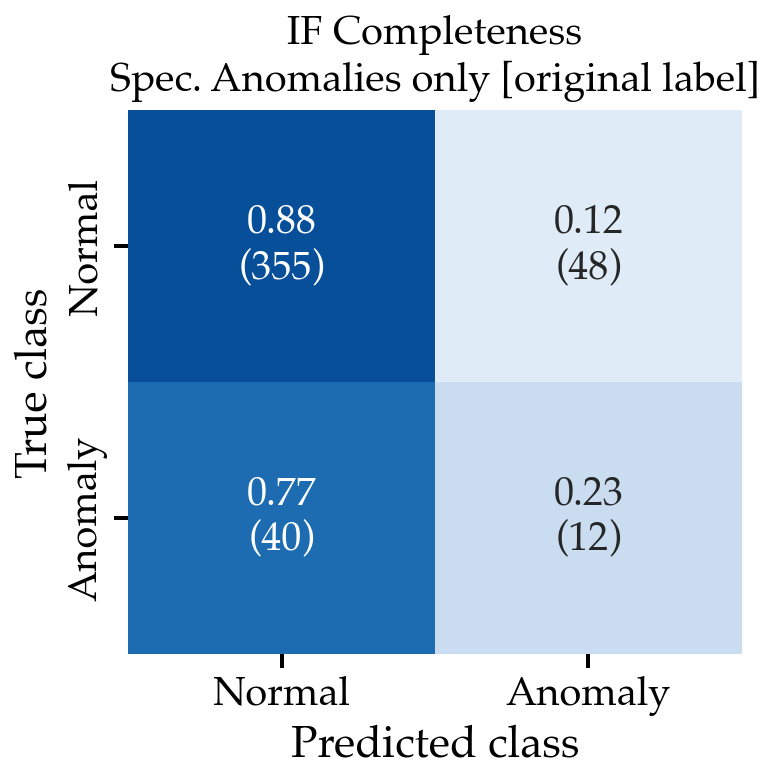

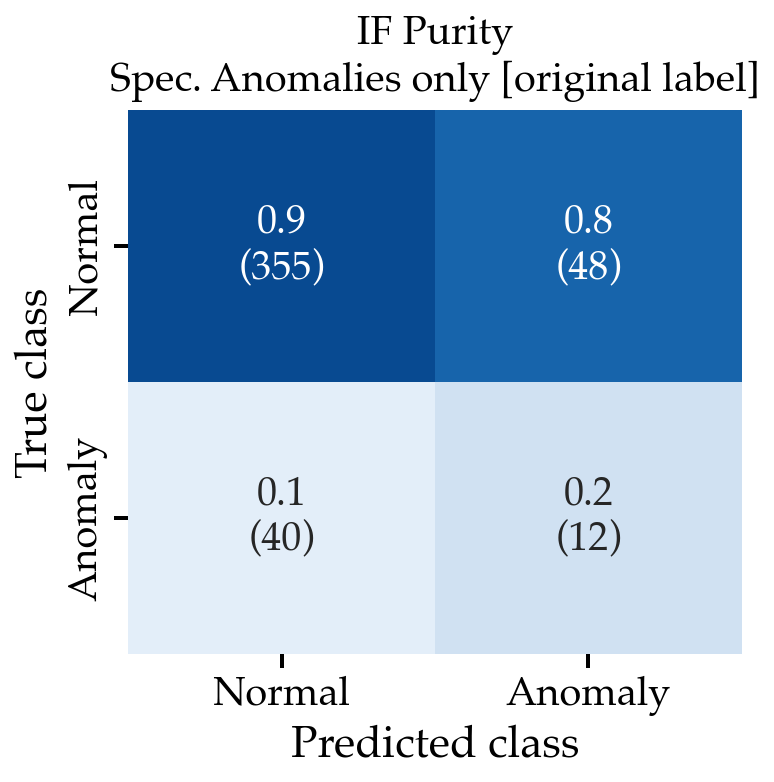

In [21]:
# Confusion matrices
title='spec_label_only'
df = IF_df
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['IF_best_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['Completeness', 'Purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, #labels=class_names
             title=f'IF {KIND}\nSpec. Anomalies only [original label]', kind=KIND)
    plt.savefig(f'{cm_path}/IF_confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Support Vector Machine

In [22]:
x_train.iloc[0:10, :]

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,6.41716,28.099199,0.218201,0.604300,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821
ZTF21aatvcdl,1.001925,0.535585,0.384615,0.076923,0.355134,2.003849,1.392731,0.589785,1.890188,0.011990,...,3.86514,13.535500,0.170500,0.299500,0.310101,0.245600,0.215601,0.188101,1.118396,0.810604
ZTF20ackzfvn,0.842765,0.292838,0.285714,0.000000,0.347289,1.685530,1.470047,0.522483,1.647548,-0.057671,...,5.57920,19.530100,0.114399,0.244598,0.381500,0.568100,0.528400,0.385101,172.179993,0.152137
ZTF21abngbrl,0.734040,0.614425,0.125000,0.000000,0.424395,1.468081,1.324121,0.883477,-0.647679,0.022412,...,12.03950,27.575800,-0.179399,0.717699,2.400501,2.056900,2.181299,1.926700,136.301710,3.633416
ZTF21aaaroyw,0.411922,0.292416,0.222222,0.000000,0.347490,0.823845,0.629479,0.208841,1.513798,-0.006436,...,15.06910,21.057301,0.118999,1.267200,1.400800,1.457999,1.562500,1.456800,65.883768,0.599778
ZTF22aabjpii,0.341308,0.206819,0.250000,0.000000,0.367030,0.682615,0.682615,0.377733,3.202045,-0.057010,...,2.48726,8.362500,-0.107199,0.000799,0.090700,0.081902,-0.046400,-0.078899,16.659563,0.219559
ZTF21abvdikq,1.127108,3.089092,0.210526,0.078947,0.397965,2.119240,1.240693,0.585167,1.230036,0.018347,...,14.39310,26.713600,0.178900,1.822201,1.980000,2.557401,2.436601,2.351601,67.004686,0.401675
ZTF21aagydov,0.344995,0.334842,0.500000,0.000000,0.358446,0.689991,0.612874,0.340182,-0.991203,0.018415,...,7.20253,21.644100,0.246799,0.510101,0.414299,0.434700,0.411800,0.404699,37.399125,0.084282
ZTF21aaqyuun,0.242481,2.661174,0.125000,0.035714,0.252732,0.371287,0.125322,0.052601,10.212823,0.000289,...,15.41620,46.257198,1.341600,2.260700,1.625099,4.475900,2.463300,2.881000,2374.399877,1.133472


In [23]:
%%time 

from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, gamma="auto", decision_function_shape="ovo", class_weight="balanced", verbose=True) # class_weight="balanced"

# Fit the classifier to the training data
svm_classifier.fit(x_train, np.array(x_train_all['tns_cls']))

# Make predictions on the test data
y_pred = svm_classifier.predict(x_test)


[LibSVM]CPU times: user 1min 46s, sys: 1.38 s, total: 1min 48s
Wall time: 1min 49s


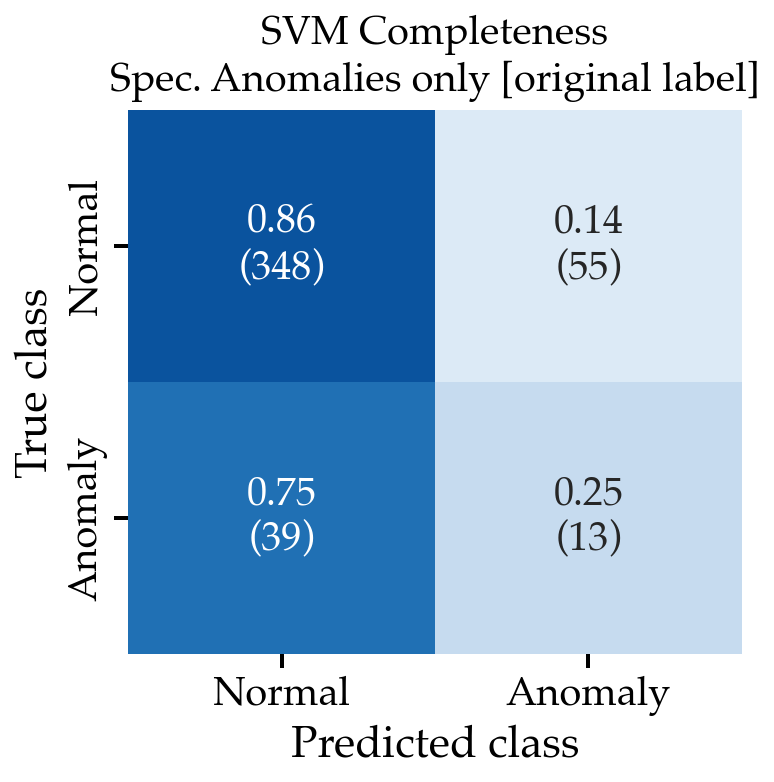

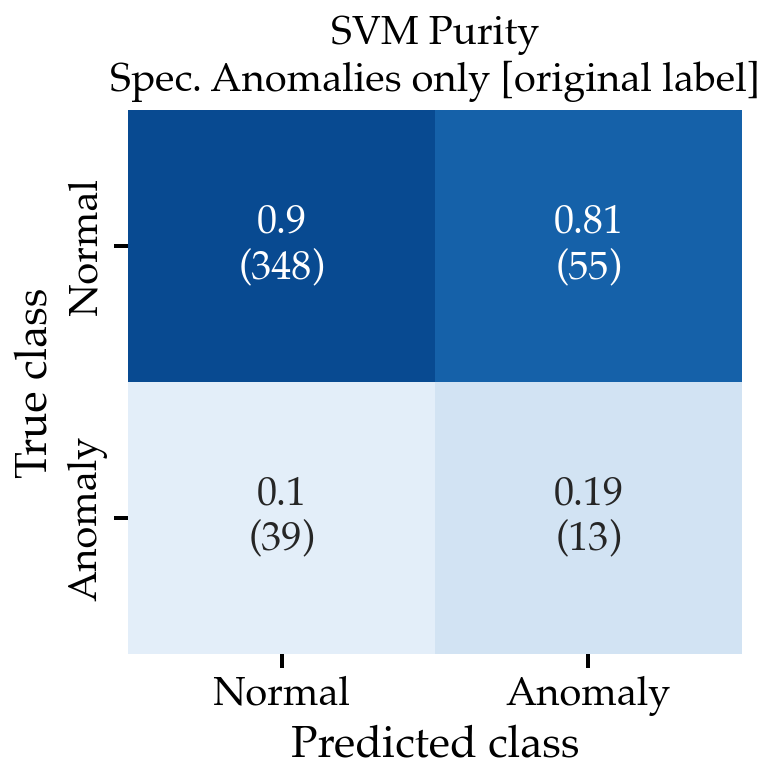

In [24]:
# Confusion matrices
title='spec_label_only'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(y_pred)
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['Completeness', 'Purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, #labels=class_names
             title=f'SVM {KIND}\nSpec. Anomalies only [original label]', kind=KIND)
    plt.savefig(f'{cm_path}/SVM_confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [25]:
comparison_df = IF_df.copy()
comparison_df["SVM_best_cls"] = np.array(y_pred)

comparison_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,dist/DLR,has_tns,tns_cls,spec_z,report_group,Normal,Other,RFC_best_cls,IF_best_cls,SVM_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.363381,Yes_TNS,Normal,0.076000,ALeRCE,80.436006,19.563994,Normal,Normal,Normal
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,1.280643,Yes_TNS,Other,0.023563,ZTF,32.037458,67.962542,Other,Normal,Normal
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.245163,Yes_TNS,Normal,0.048167,ZTF,70.000000,30.000000,Normal,Normal,Normal
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.282454,Yes_TNS,Normal,0.041000,ALeRCE,94.000000,6.000000,Normal,Normal,Normal
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,4.749794,Yes_TNS,Normal,0.070000,ALeRCE,79.000000,21.000000,Normal,Normal,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.124452,Yes_TNS,Normal,0.037437,ALeRCE,92.000000,8.000000,Normal,Normal,Normal
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.012833,Yes_TNS,Normal,0.097780,AMPEL,86.000000,14.000000,Normal,Normal,Normal
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.916609,Yes_TNS,Normal,0.040000,ALeRCE,87.000000,13.000000,Normal,Other,Normal


In [26]:
print("obj, cls, rfc_cls, if_cls, svm_cls")
for obj, cls, rfc_cls, if_cls, svm_cls in zip(comparison_df.index, comparison_df.tns_cls, 
                                              comparison_df.RFC_best_cls, comparison_df.IF_best_cls, comparison_df.SVM_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls, if_cls, svm_cls)

obj, cls, rfc_cls, if_cls, svm_cls
https://alerce.online/object/ZTF21aazebgh Normal Normal Normal Normal
https://alerce.online/object/ZTF21acgxypn Other Other Normal Normal
https://alerce.online/object/ZTF19aapqqrb Normal Normal Normal Normal
https://alerce.online/object/ZTF21aasbxng Normal Normal Normal Normal
https://alerce.online/object/ZTF21aaglgcb Normal Normal Normal Other
https://alerce.online/object/ZTF21aanwfjk Normal Normal Normal Normal
https://alerce.online/object/ZTF21abcixor Normal Normal Normal Normal
https://alerce.online/object/ZTF21abgkfzh Other Normal Normal Other
https://alerce.online/object/ZTF21aarerya Normal Normal Other Normal
https://alerce.online/object/ZTF21abvvuhm Normal Normal Normal Normal
https://alerce.online/object/ZTF21acivpbd Normal Normal Normal Normal
https://alerce.online/object/ZTF21abjtqyq Normal Normal Normal Normal
https://alerce.online/object/ZTF21abotose Other Normal Normal Normal
https://alerce.online/object/ZTF21aafjjee Normal Normal Normal

https://alerce.online/object/ZTF21acilvjb Normal Normal Normal Normal
https://alerce.online/object/ZTF22aaaehtn Normal Normal Normal Normal
https://alerce.online/object/ZTF21aagtqgq Normal Normal Normal Normal
https://alerce.online/object/ZTF21aagoliy Normal Normal Normal Normal
https://alerce.online/object/ZTF21aadatfg Other Normal Normal Other
https://alerce.online/object/ZTF21aasafkl Normal Normal Normal Normal
https://alerce.online/object/ZTF21aasbjgq Normal Normal Normal Normal
https://alerce.online/object/ZTF21abxzzys Normal Normal Normal Normal
https://alerce.online/object/ZTF18abuxjrd Normal Normal Normal Normal
https://alerce.online/object/ZTF20acgchsp Normal Normal Normal Other
https://alerce.online/object/ZTF21aaoqbbw Other Normal Normal Normal
https://alerce.online/object/ZTF21aabfwwl Normal Normal Normal Normal
https://alerce.online/object/ZTF21aatwlhj Normal Normal Normal Normal
https://alerce.online/object/ZTF21aaxxoei Normal Normal Normal Other
https://alerce.online/obj

In [27]:
SVM_anom_df = comparison_df[comparison_df["SVM_best_cls"] == "Other"]

for obj in SVM_anom_df.index:
    print(f"https://alerce.online/object/{obj}")

https://alerce.online/object/ZTF21aaglgcb
https://alerce.online/object/ZTF21abgkfzh
https://alerce.online/object/ZTF21achfddh
https://alerce.online/object/ZTF22aaagrce
https://alerce.online/object/ZTF20acppsay
https://alerce.online/object/ZTF21aanyfqu
https://alerce.online/object/ZTF18abquxjv
https://alerce.online/object/ZTF21abflgpq
https://alerce.online/object/ZTF21abhrmrv
https://alerce.online/object/ZTF21abzbwfo
https://alerce.online/object/ZTF21aarejnt
https://alerce.online/object/ZTF20acowcee
https://alerce.online/object/ZTF21aaffxdt
https://alerce.online/object/ZTF21aamwqim
https://alerce.online/object/ZTF21aajvukh
https://alerce.online/object/ZTF20acwyihb
https://alerce.online/object/ZTF21abcnpnk
https://alerce.online/object/ZTF22aaabnwa
https://alerce.online/object/ZTF22aaaeeva
https://alerce.online/object/ZTF21aakigqr
https://alerce.online/object/ZTF20abvquuo
https://alerce.online/object/ZTF21aautijg
https://alerce.online/object/ZTF20acjdhof
https://alerce.online/object/ZTF21

In [28]:
# Common failure modes



# VAE

In [29]:
%%time 

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

seed_value = 11

# Set Python random seed
random.seed(seed_value)

# Set NumPy random seed
np.random.seed(seed_value)

# Set TensorFlow random seed
tf.random.set_seed(seed_value)

# Set the random seed for TensorFlow/Keras layers
tf.keras.backend.clear_session()  # Clear any existing models or layers

# Encode string labels to numerical values
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(np.array(x_train_all['tns_cls']))
y_test = label_encoder.fit_transform(np.array(x_test_all['tns_cls']))

# Split the data into training and testing sets
X_train, X_test = x_train_normalized, x_test_normalized


# VAE Parameters
input_dim = X_train.shape[1]
latent_dim = 3
intermediate_dim = 64

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE Model
vae = Model(inputs, x_decoded_mean)

# VAE Loss
reconstruction_loss = binary_crossentropy(inputs, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

# Train the VAE
history = vae.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

# Encoder model to extract features
encoder = Model(inputs, z_mean)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Custom loss function to give more weight to the "Other" class
def custom_loss(y_true, y_pred):
    weight = 0.90
    y_true = tf.cast(y_true, tf.float32)
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=weight)
    return tf.reduce_mean(loss)

# Simple neural network for classification
classifier = Sequential()
classifier.add(Dense(10, activation='relu', input_dim=latent_dim))
classifier.add(Dense(1, activation='sigmoid'))

# Compile the model with precision and recall as metrics
classifier.compile(optimizer='adam', loss=custom_loss, metrics=[Precision()])
classifier.summary()

# Train the classifier on encoded features
classifier.fit(X_train_encoded, y_train, epochs=50, batch_size=64, validation_data=(X_test_encoded, y_test))

# Make predictions and evaluate the classifier
y_pred_encoded = (classifier.predict(X_test_encoded) > 0.5).astype("int32")

# Decode the numerical predictions back to string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded.flatten())
y_test_decoded = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_decoded, y_pred)
precision = precision_score(y_test_decoded, y_pred, pos_label='Other')  # Specify the positive class label
recall = recall_score(y_test_decoded, y_pred, pos_label='Other')
report = classification_report(y_test_decoded, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Classification Report:\n", report)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   7744      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 3)                    195       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 3)                    195       ['dense[0][0]']               
                                                                                              

Epoch 17/50
115/115 [==============================] - 0s 2ms/step - loss: -419970400.0000 - val_loss: -386358720.0000
Epoch 18/50
115/115 [==============================] - 0s 2ms/step - loss: -493981472.0000 - val_loss: -451615872.0000
Epoch 19/50
115/115 [==============================] - 0s 2ms/step - loss: -574850176.0000 - val_loss: -523096832.0000
Epoch 20/50
115/115 [==============================] - 0s 2ms/step - loss: -668285632.0000 - val_loss: -600649024.0000
Epoch 21/50
115/115 [==============================] - 0s 2ms/step - loss: -764048448.0000 - val_loss: -684897792.0000
Epoch 22/50
115/115 [==============================] - 0s 2ms/step - loss: -863696192.0000 - val_loss: -775849024.0000
Epoch 23/50
115/115 [==============================] - 0s 2ms/step - loss: -973633216.0000 - val_loss: -873352192.0000
Epoch 24/50
115/115 [==============================] - 0s 4ms/step - loss: -1089562112.0000 - val_loss: -977931520.0000
Epoch 25/50
115/115 [==========================

Epoch 15/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6371 - precision: 0.7591 - val_loss: 0.7231 - val_precision: 0.0938
Epoch 16/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6370 - precision: 0.7733 - val_loss: 0.7243 - val_precision: 0.0909
Epoch 17/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6368 - precision: 0.7743 - val_loss: 0.7367 - val_precision: 0.1111
Epoch 18/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6333 - precision: 0.7244 - val_loss: 0.7727 - val_precision: 0.1358
Epoch 19/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6346 - precision: 0.7613 - val_loss: 0.7481 - val_precision: 0.1228
Epoch 20/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6377 - precision: 0.6925 - val_loss: 0.8018 - val_precision: 0.1308
Epoch 21/50
457/457 [==============================] - 1s 1ms/step - loss: 0.6403 - precision: 0.6783 - val_loss: 0.8028 - val_pre

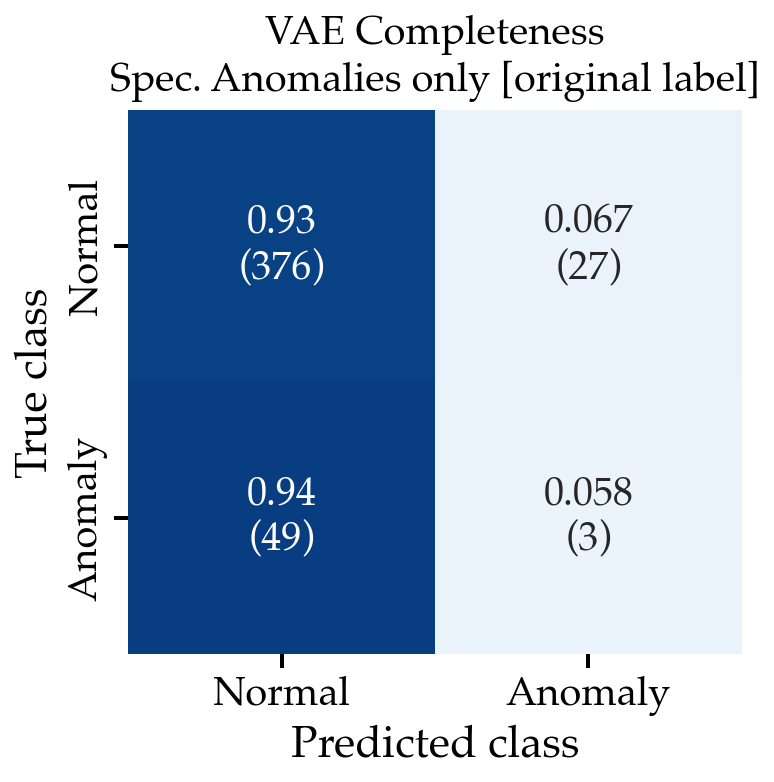

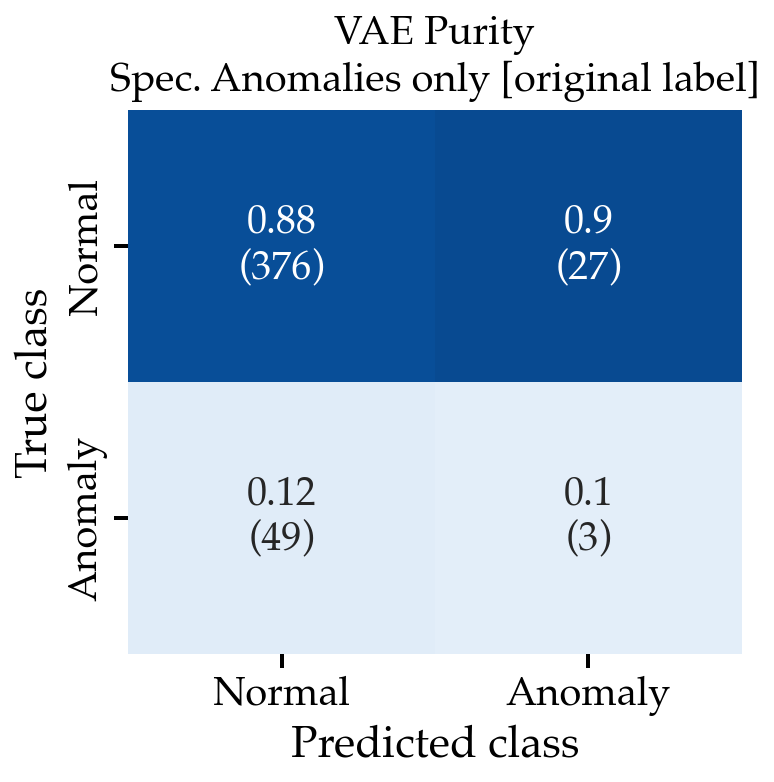

In [30]:
# Confusion matrices
title='spec_label_only'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(y_pred)
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['Completeness', 'Purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, #labels=class_names
             title=f'VAE {KIND}\nSpec. Anomalies only [original label]', kind=KIND)
    plt.savefig(f'{cm_path}/VAE_confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [31]:
# # Assuming you have a list of loss values named "loss_history"

# loss_history = history.history['loss']
# epochs = range(1, len(loss_history) + 1)

# # Plot the loss curve
# plt.plot(epochs[1:], loss_history[1:], label='Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

# plt.show()

In [32]:
# 50 then 75 epochs, batch 256, weight 1, latent dim 3, is good (33 anom predicted)

In [33]:
comparison_df["VAE_best_cls"] = np.array(y_pred)

comparison_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,has_tns,tns_cls,spec_z,report_group,Normal,Other,RFC_best_cls,IF_best_cls,SVM_best_cls,VAE_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,Yes_TNS,Normal,0.076000,ALeRCE,80.436006,19.563994,Normal,Normal,Normal,Normal
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,Yes_TNS,Other,0.023563,ZTF,32.037458,67.962542,Other,Normal,Normal,Normal
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,Yes_TNS,Normal,0.048167,ZTF,70.000000,30.000000,Normal,Normal,Normal,Normal
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,Yes_TNS,Normal,0.041000,ALeRCE,94.000000,6.000000,Normal,Normal,Normal,Other
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,Yes_TNS,Normal,0.070000,ALeRCE,79.000000,21.000000,Normal,Normal,Other,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,Yes_TNS,Normal,0.037437,ALeRCE,92.000000,8.000000,Normal,Normal,Normal,Normal
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,Yes_TNS,Normal,0.097780,AMPEL,86.000000,14.000000,Normal,Normal,Normal,Normal
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,Yes_TNS,Normal,0.040000,ALeRCE,87.000000,13.000000,Normal,Other,Normal,Normal


In [34]:
VAE_anom_df = comparison_df[comparison_df["VAE_best_cls"] == "Other"]

for obj in VAE_anom_df.index:
    print(f"https://alerce.online/object/{obj}")

https://alerce.online/object/ZTF21aasbxng
https://alerce.online/object/ZTF20acjsazw
https://alerce.online/object/ZTF21aanyfqu
https://alerce.online/object/ZTF20adadshh
https://alerce.online/object/ZTF21aamwqim
https://alerce.online/object/ZTF21aajvukh
https://alerce.online/object/ZTF21abcmtev
https://alerce.online/object/ZTF20abyzomt
https://alerce.online/object/ZTF20accmtgt
https://alerce.online/object/ZTF20acueziy
https://alerce.online/object/ZTF21aagmoqw
https://alerce.online/object/ZTF20abweedo
https://alerce.online/object/ZTF21aaoekcj
https://alerce.online/object/ZTF22aaaepjq
https://alerce.online/object/ZTF21aahsqng
https://alerce.online/object/ZTF18aaoxrup
https://alerce.online/object/ZTF21aaswtok
https://alerce.online/object/ZTF21aajgdpo
https://alerce.online/object/ZTF21aaqugxm
https://alerce.online/object/ZTF20acgiglu
https://alerce.online/object/ZTF21aaukcog
https://alerce.online/object/ZTF20acgchsp
https://alerce.online/object/ZTF20abrjmgi
https://alerce.online/object/ZTF20

In [35]:
# Common failure modes



In [36]:
# changing weight skews predictions heavily to all anom or all normal

In [37]:
33/455

0.07252747252747253

In [38]:
29/455

0.06373626373626373

In [39]:
len(anomaly_scores[(anomaly_scores) > 0])

395

In [40]:
np.min(anomaly_scores)

-0.16907110499703493

In [41]:
60/455

0.13186813186813187

In [42]:
68/455

0.14945054945054945

In [43]:
30/455

0.06593406593406594